In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

!pip install -U scikit-learn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Filter Country name
def extract_countries(text):
    # Danh sách quốc gia cần giữ lại
    countries = [
        'US', 'UK', 'British', 'Brazilian', 'Canadian', 'Dutch', 'French', 'Germany', 'Canada', 'Japanese', 'Australia', 'Indian', 'Indonesian', 'Egyptian', 'African', 'Filipino', 'Singaporean', 'Thai', 'Thailan', 'Vietnamese',
        'Korean', 'Taiwanese', 'Swedish', 'Chinese', 'Finnish', 'Argentinian', 'Polish', 'Danish', 'Romanian', 'Danish', 'Mexican', 'Nollywood', 'Turkish', 'Spanish', 'Peruvian', 'Saudi', 'Swedish', 'Italian', 'Malaysian'
    ]

    # Tìm các quốc gia trong danh sách
    found_countries = [country for country in countries if country in text]

    # Trả về các quốc gia tìm thấy (hoặc chuỗi rỗng nếu không tìm thấy quốc gia nào)
    return ', '.join(found_countries) if found_countries else None

# Transform word to lemmas, ex: "running" -> "run", "better" -> "good"
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
  return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Remove all Html
def clearHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    return cleantext

# Keep letters, number and ', remove other character and space
def clearPunc(sentence):
    cleaned = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    return cleaned

# Keep letters and number, space, remove the others
def remove_punctuation(sentence):
    cleaned = re.sub(r'[^\w\s]', '', sentence)
    return cleaned

# Spelling error: Use library TextBlob or SymSpell
from textblob import TextBlob

def correct_spelling(sentence):
  blob = TextBlob(sentence)
  return str(blob.correct())

# Transform uppercase to lowercase
def to_lowercase(sentence):
  return sentence.lower()

# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(sentence):
  words = sentence.split()
  filtered = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered)

# Remove extra whitespace
def remove_extra_whitespace(sentence):
  return ' '.join(sentence.split())

# Remove all whitespace
def remove_whitespace(df, column_name):
  df[column_name] = df[column_name].str.replace(r'\s+', '', regex=True)
  return df

# Unicode normalization
import unicodedata

def normalize_uniqcode(sentence):
  return unicodedata.normalize('NFKD', sentence)

# Remove URL and email
def remove_url(sentence):
  cleaned = re.sub(r'http\S+|www\S+|@\S+|[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', sentence)
  return cleaned

# Special character handling: Remove or replace custom characters
def replace_specific_chars(sentence):
  replacements = {'$': 'dollar', '&': 'and', '@': 'at'}
  for char, repl in replacements.items():
    sentence = sentence.replace(char, repl)
  return sentence

In [3]:
# CRAWLED MOVIE: CLEAN DATA
crawl_movie = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NETFLIX/Crawled Data/Netflix_Crawl_Data.csv')
crawl_movie.drop(['Type'], axis=1, inplace=True)
crawl_movie['Country'] = crawl_movie['Genres'].apply(extract_countries)

crawl_movie.isnull().sum()
crawl_movie.duplicated().sum()
crawl_movie.drop_duplicates(inplace=True)
mode_country = crawl_movie['Country'].mode()[0]
crawl_movie['Country'] = crawl_movie['Country'].fillna(mode_country)
crawl_movie.dropna(inplace=True)
crawl_movie.reset_index(drop=True, inplace=True)
crawl_movie['Release Year'] = crawl_movie['Release Year'].astype(int)

print('Done')

Done


In [4]:
crawl_movie.info()
crawl_movie.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4254 entries, 0 to 4253
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            4254 non-null   object
 1   Release Year     4254 non-null   int64 
 2   Description      4254 non-null   object
 3   Director         4254 non-null   object
 4   Cast             4254 non-null   object
 5   Genres           4254 non-null   object
 6   Sub-genres       4254 non-null   object
 7   Maturity Rating  4254 non-null   object
 8   Country          4254 non-null   object
dtypes: int64(1), object(8)
memory usage: 299.2+ KB


,Title,Release Year,Description,Director,Cast,Genres,Sub-genres,Maturity Rating,Country
0,Eastern Promises,2007,A notorious gangster learns that a midwife has...,David Cronenberg,"Viggo Mortensen, Sinéad Cusack, Donald Sumpter...","Mystery Movies, Crime Movies, US Movies, Thril...","Gritty, Violent, Dark",T18,US
1,Upstream,2024,"After losing his white collar job, a father fa...",Xu Zheng,"Xin Zhilei, Wang Xiao, Ding Jiali, Chen Halin,...","Movies Based on Books, Chinese Movies, Mainlan...","Inspiring, Sentimental, Heartfelt",T13,Chinese
2,The Killer,2023,★★★★★ — The Guardian. Director David Fincher a...,David Fincher,"Michael Fassbender, Sala Baker, Tilda Swinton,...","Thriller Movies, US Movies, Crime Movies, Dram...","Dark, Psychological, Suspenseful",T18,US
3,The Intruder,2019,After moving into their Napa Valley dream hous...,Deon Taylor,"Michael Ealy, Meagan Good, Joseph Sikora, Kurt...","Thriller Movies, US Movies","Suspenseful, Psychological",T16,US
4,How To Make Millions Before Grandma Dies,2024,A young man becomes a caretaker for his ailing...,Pat Boonnitipat,"Sarinrat Thomas, Usha Seamkhum, Himawari Tajir...","Drama Movies, Thai","Intimate, Sentimental, Heartfelt",K,Thai


Text(0, 0.5, '')

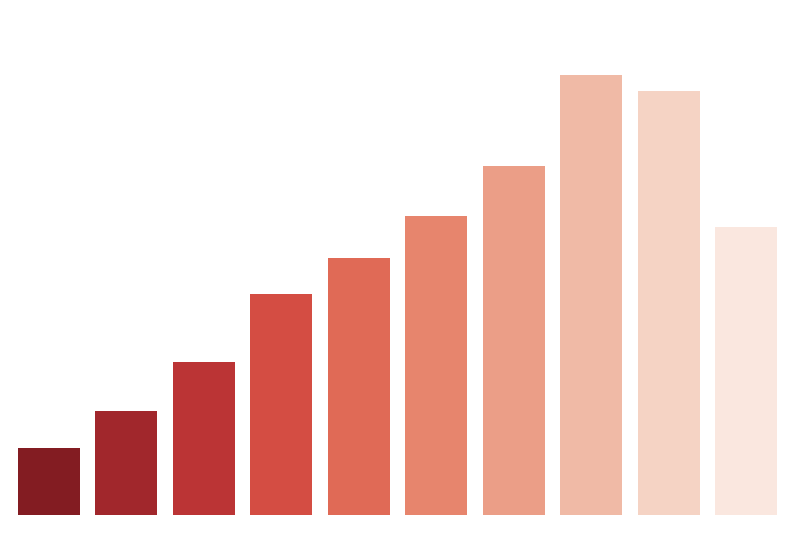

In [5]:
# MOVIE RELEASE YEAR: NUMBER OF MOVIE
movie_year = crawl_movie.groupby('Release Year').size().reset_index(name='Quantity')
movie_year = movie_year.sort_values(by='Quantity', ascending=False).head(10)
movie_year = movie_year.reset_index(drop=True)

fig = plt.figure(figsize=(10,6))
myear_chart = sns.barplot(movie_year, x='Release Year', y='Quantity', palette='Reds_r')

for a in myear_chart.patches:
  if a.get_height() > 0:
    myear_chart.annotate(f'{int(a.get_height())}',
                        (a.get_x() + a.get_width() / 2, a.get_height()+10),
                        ha='center', va='bottom', fontsize=12, color='white', fontweight='semibold')
  a.set_zorder(3)

sns.despine()
# plt.legend(frameon=False)
myear_chart.spines['left'].set_visible(False)
myear_chart.spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, color='darkgray')
plt.xticks(fontsize=11, color='white')
plt.yticks([])
plt.gca().set_facecolor('none')
fig.patch.set_alpha(0)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.3, zorder=0)

plt.title('MOVIE | RELEASE YEAR: NUMBER OF MOVIES', fontsize=16, color='white', fontweight='semibold', loc='left', pad=20)
plt.xlabel('', fontsize=14, labelpad=20, color='white', fontweight='semibold')
plt.ylabel('')

Text(0, 0.5, '')

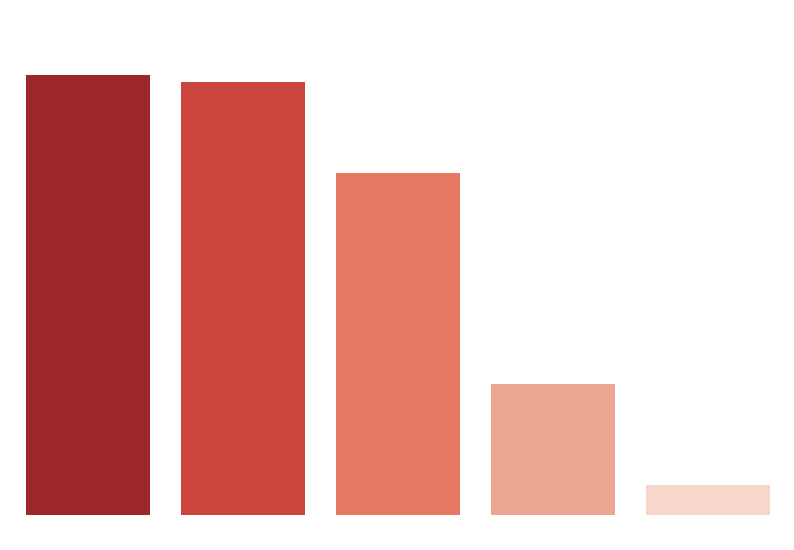

In [6]:
# MOVIE MATURITY RATING: DISTRIBUTION
movie_mature = crawl_movie.groupby('Maturity Rating').size().reset_index(name='Quantity')
movie_mature = movie_mature.sort_values(by='Quantity', ascending=False)
movie_mature = movie_mature.reset_index(drop=True)

fig = plt.figure(figsize=(10,6))
mature_chart = sns.barplot(movie_mature, x='Maturity Rating', y='Quantity', palette='Reds_r')

for a in mature_chart.patches:
  if a.get_height() > 0:
    mature_chart.annotate(f'{int(a.get_height())}',
                        (a.get_x() + a.get_width() / 2, a.get_height()+10),
                        ha='center', va='bottom', fontsize=12, color='white', fontweight='semibold')
  a.set_zorder(3)

sns.despine()
# plt.legend(frameon=False)
mature_chart.spines['left'].set_visible(False)
mature_chart.spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, color='darkgray')
plt.xticks(fontsize=11, color='white', ticks=range(len(movie_mature['Maturity Rating'])), labels=[label.replace(' ', '\n') for label in movie_mature['Maturity Rating']])
plt.yticks([])
plt.gca().set_facecolor('none')
fig.patch.set_alpha(0)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.3, zorder=0)

plt.title('MOVIE | MATURITY RATING: NUMBER OF MOVIES', fontsize=16, color='white', fontweight='semibold', loc='left', pad=20)
plt.xlabel('', fontsize=14, labelpad=20, color='white', fontweight='semibold')
plt.ylabel('')

In [7]:
# IMDB: CLEAN DATA
imdb = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NETFLIX/Netflix IMDB Scores/Netflix TV Shows and Movies.csv')
imdb.isnull().sum()
imdb.drop(['index','age_certification','type','description','release_year','runtime','imdb_votes'], axis=1, inplace=True)
imdb.dropna(inplace=True)
imdb.info()
imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5283 entries, 0 to 5282
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5283 non-null   object 
 1   title       5283 non-null   object 
 2   imdb_id     5283 non-null   object 
 3   imdb_score  5283 non-null   float64
dtypes: float64(1), object(3)
memory usage: 165.2+ KB


,id,title,imdb_id,imdb_score
0,tm84618,Taxi Driver,tt0075314,8.3
1,tm127384,Monty Python and the Holy Grail,tt0071853,8.2
2,tm70993,Life of Brian,tt0079470,8.0
3,tm190788,The Exorcist,tt0070047,8.1
4,ts22164,Monty Python's Flying Circus,tt0063929,8.8


**MERGE TABLE TO CREATE TRAIN - TEST**

In [8]:
# MERGE: MOVIE DATA VÀ IMDB SCORE, chỉ lấy phim có trong cả hai bảng
mo_imdb = pd.merge(crawl_movie, imdb, left_on='Title', right_on='title', how='inner')
mo_imdb.drop(['id','imdb_id','title'], axis=1, inplace=True)
mo_imdb.info()
mo_imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            1339 non-null   object 
 1   Release Year     1339 non-null   int64  
 2   Description      1339 non-null   object 
 3   Director         1339 non-null   object 
 4   Cast             1339 non-null   object 
 5   Genres           1339 non-null   object 
 6   Sub-genres       1339 non-null   object 
 7   Maturity Rating  1339 non-null   object 
 8   Country          1339 non-null   object 
 9   imdb_score       1339 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 104.7+ KB


,Title,Release Year,Description,Director,Cast,Genres,Sub-genres,Maturity Rating,Country,imdb_score
0,The Killer,2023,★★★★★ — The Guardian. Director David Fincher a...,David Fincher,"Michael Fassbender, Sala Baker, Tilda Swinton,...","Thriller Movies, US Movies, Crime Movies, Dram...","Dark, Psychological, Suspenseful",T18,US,6.0
1,Ad Vitam,2025,When he and his pregnant wife are attacked in ...,Rodolphe Lauga,"Johan Heldenbergh, Stéphane Caillard, Alexis M...","Thriller Movies, French, Drama Movies, Crime M...","Gritty, Exciting",T16,French,6.4
2,Kingdom,2019,"After his friend dies in service to the king, ...",Shinsuke Sato,"Jun Hashimoto, Ryo Yoshizawa, Renji Ishibashi,...","Military Movies, Period Pieces, Japanese, Acti...","Exciting, Rousing",T16,Japanese,8.3
3,Seven Years in Tibet,1997,An Austrian mountain climber's escape from a W...,Jean-Jacques Annaud,"Ingeborga Dapkunaite, Mako, Jamyang Jamtsho Wa...","Movies Based on Real Life, US Movies, Action &...","Understated, Inspiring",T13,US,7.1
4,Forgotten,2017,When his abducted brother returns seemingly a ...,Jang Hang-jun,"Moon Seng-keun, Kang Ha-neul, Kim Moo-yeol, Na...","Thriller Movies, Drama Movies, Korean, Crime M...","Suspenseful, Psychological",T16,Korean,7.4


In [9]:
mo_imdb['imdb_score'].sort_values().unique()

array([1.7, 2.1, 2.2, 2.5, 2.6, 2.7, 2.8, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1,
       6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4,
       7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.5, 8.6, 8.7, 8.8,
       9. ])

Text(0, 0.5, '')

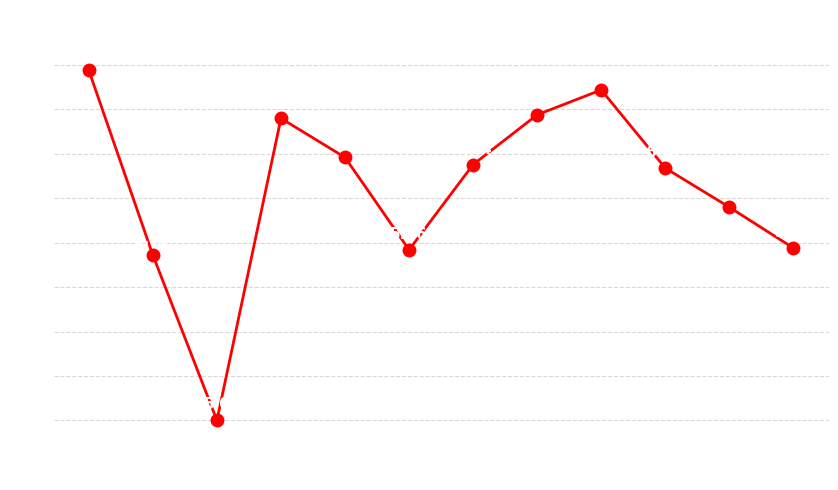

In [10]:
# MOVIE RELEASE YEAR: AVERAGE IMDB_SCORE

# Binning years into ranges
bins = [1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020,2025]
labels = ['1966\n-1970', '1971\n-1975', '1976\n-1980', '1981\n-1985', '1986\n-1990', '1991\n-1995', '1996\n-2000', '2001\n-2005', '2006\n-2010', '2011\n-2015', '2016\n-2020', '2021\n-2025']
mo_imdb['Year'] = pd.cut(mo_imdb['Release Year'], bins=bins, labels=labels, right=True)
year_score = mo_imdb.groupby(['Year'])['imdb_score'].mean().round(2).reset_index(name='Avg_IMDBscore')  # Tính điểm trung bình theo Year

# Merge table
mo_imdb = mo_imdb.merge(year_score, on='Year')
mo_imdb

# Create chart
fig = plt.figure(figsize=(10,5))
yearscore_line = sns.lineplot(data=year_score, x='Year', y='Avg_IMDBscore', color='Red', linewidth=2, marker='o', markersize=10, markeredgewidth=0)

# Display values
for a in range(len(year_score)):
  #if a.get_height() > 0:
    x = a
    y = year_score['Avg_IMDBscore'].iloc[a]
    plt.text(a, y+0.05, f'{y}', ha='center', va='bottom', fontsize=11, color='white', fontweight='semibold')

# Polishing
sns.despine()
yearscore_line.spines['left'].set_visible(False)
yearscore_line.spines['bottom'].set_visible(False)
plt.legend(frameon=False)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.3, zorder=0)
plt.gca().tick_params(left=False, bottom=False)
plt.xticks(fontsize=11, color='white')
plt.yticks(fontsize=11, color='white')
plt.gca().set_facecolor('none')
fig.patch.set_alpha(0)

# Labeling
plt.title('MOVIE - RELEASE YEAR: AVERAGE IMDB SCORE', fontsize=16, color='white', fontweight='semibold', loc='left', pad=20)
plt.xlabel('')
plt.ylabel('')

In [11]:
# PREPROCESSING
mo_prep = mo_imdb[['Release Year','Description','Director','Cast','Genres','Sub-genres','Maturity Rating','Country', 'imdb_score']]
mo_prep = remove_whitespace(mo_prep,'Director')  # remove whitespace to create personal name
mo_prep = remove_whitespace(mo_prep,'Cast')  # remove whitespace to create personal name
mo_prep['Description'] = mo_prep['Description'].apply(clearHtml).apply(clearPunc).apply(to_lowercase).apply(remove_stopwords).apply(remove_extra_whitespace).apply(normalize_uniqcode).apply(remove_url).apply(replace_specific_chars).apply(lemmatize_text)
mo_prep['Director'] = mo_prep['Director'].apply(clearHtml).apply(clearPunc).apply(to_lowercase).apply(remove_stopwords).apply(remove_extra_whitespace).apply(normalize_uniqcode).apply(remove_url).apply(replace_specific_chars).apply(lemmatize_text)
mo_prep['Cast'] = mo_prep['Cast'].apply(clearHtml).apply(clearPunc).apply(to_lowercase).apply(remove_stopwords).apply(remove_extra_whitespace).apply(normalize_uniqcode).apply(remove_url).apply(replace_specific_chars).apply(lemmatize_text)
mo_prep['Genres'] = mo_prep['Genres'].apply(clearHtml).apply(clearPunc).apply(to_lowercase).apply(remove_stopwords).apply(remove_extra_whitespace).apply(normalize_uniqcode).apply(remove_url).apply(replace_specific_chars).apply(lemmatize_text)
mo_prep['Sub-genres'] = mo_prep['Sub-genres'].apply(clearHtml).apply(clearPunc).apply(to_lowercase).apply(remove_stopwords).apply(remove_extra_whitespace).apply(normalize_uniqcode).apply(remove_url).apply(replace_specific_chars).apply(lemmatize_text)
mo_prep['Country'] = mo_prep['Country'].replace({'African, Nollywood': 'African', 'Swedish, Swedish': 'Swedish', 'Taiwanese, Chinese': 'Taiwanese'})

oe = OrdinalEncoder(categories=[['K','P','T13','T16','T18']])
mo_prep['Maturity Rating Code'] = oe.fit_transform(mo_imdb[['Maturity Rating']]).astype(int)
mo_prep['Release Year'] = mo_prep['Release Year'].astype(int)

mo_prep.dropna(inplace=True)
mo_prep.reset_index(drop=True, inplace=True)

mo_prep = mo_prep[mo_prep['imdb_score']>=5]
mo_prep.info()
mo_prep.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1188 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Release Year          1188 non-null   int64  
 1   Description           1188 non-null   object 
 2   Director              1188 non-null   object 
 3   Cast                  1188 non-null   object 
 4   Genres                1188 non-null   object 
 5   Sub-genres            1188 non-null   object 
 6   Maturity Rating       1188 non-null   object 
 7   Country               1188 non-null   object 
 8   imdb_score            1188 non-null   float64
 9   Maturity Rating Code  1188 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 102.1+ KB


,Release Year,Description,Director,Cast,Genres,Sub-genres,Maturity Rating,Country,imdb_score,Maturity Rating Code
0,2023,guardian director david fincher star michael f...,davidfincher,michaelfassbender salabaker tildaswinton sophi...,thriller movie u movie crime movie drama movie,dark psychological suspenseful,T18,US,6.0,4
1,2025,pregnant wife attacked home former elite agent...,rodolphelauga,johanheldenbergh st phanecaillard alexismanent...,thriller movie french drama movie crime movie ...,gritty exciting,T16,French,6.4,3
2,2019,friend dy service king war orphan take sword v...,shinsukesato,junhashimoto ryoyoshizawa renjiishibashi watar...,military movie period piece japanese action ad...,exciting rousing,T16,Japanese,8.3,3
3,1997,austrian mountain climber escape wwii pow camp...,jean jacquesannaud,ingeborgadapkunaite mako jamyangjamtshowangchu...,movie based real life u movie action adventure...,understated inspiring,T13,US,7.1,2
4,2017,abducted brother return seemingly different ma...,janghang jun,moonseng keun kangha neul kimmoo yeol nayoung ...,thriller movie drama movie korean crime movie ...,suspenseful psychological,T16,Korean,7.4,3


Text(0, 0.5, '')

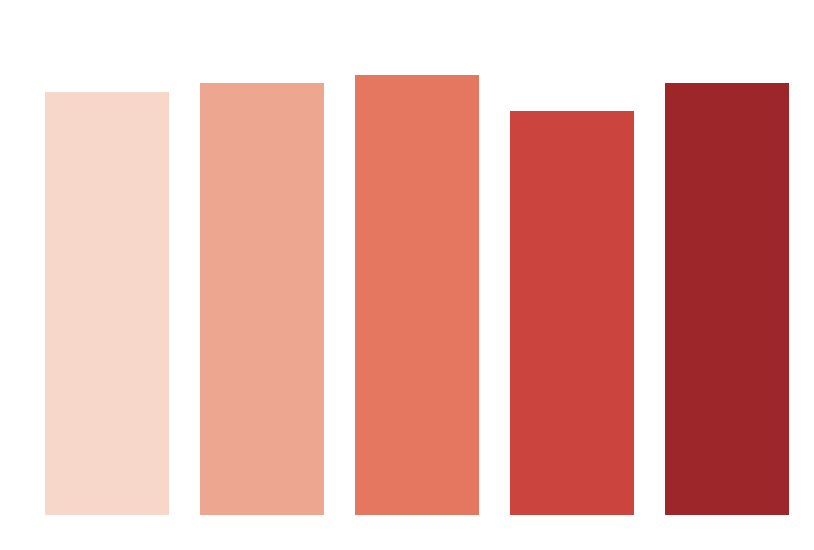

In [12]:
# MOVIE MATURITY RATING CODE: AVERAGE IMDB_SCORE
MR_score = mo_prep.groupby(['Maturity Rating'])['imdb_score'].mean().round(2).reset_index(name='Avg IMDBscore')  # Tính điểm trung bình theo Year
MR_score = MR_score.sort_values(by='Maturity Rating', ascending=False).head(10)
MR_score

# Create chart
fig = plt.figure(figsize=(10,6))
barchart = sns.barplot(data=MR_score, x='Maturity Rating', y='Avg IMDBscore', palette='Reds')

# Display values
for a in barchart.patches:
  if a.get_height() > 0:
    barchart.annotate(f'{a.get_height()}',
                        (a.get_x() + a.get_width() / 2, a.get_height()+0.1),
                        ha='center', va='bottom', fontsize=12, color='white',fontweight='semibold')
  a.set_zorder(3)

# Polishing
sns.despine()
barchart.spines['left'].set_visible(False)
barchart.spines['bottom'].set_visible(False)
plt.legend(frameon=False)
# plt.grid(axis='y', color='gray', linestyle='--', alpha=0.3, zorder=0)
plt.gca().tick_params(left=False, bottom=False)
plt.xticks(fontsize=11, color='white')
plt.yticks(fontsize=11, color='white')
plt.gca().set_facecolor('none')
fig.patch.set_alpha(0)

# Labeling
plt.title('MOVIE | MATURITY RATING: AVERAGE IMDB SCORE', fontsize=16, color='white', fontweight='semibold', loc='left', pad=20)
plt.xlabel('')
plt.ylabel('')

In [13]:
# ENCODING
mo_encode = mo_prep[['Release Year','Description','Director','Cast','Genres','Sub-genres','Maturity Rating Code', 'Country','imdb_score']]

# DIRECTOR: Mean imdb_score by Director
director_mean = mo_encode.groupby('Director')['imdb_score'].mean()
mo_encode['Director_encoded'] = mo_encode['Director'].map(director_mean)

# Use TF-IDF
# CAST
TFvectorizer = TfidfVectorizer()
cast_tf = TFvectorizer.fit_transform(mo_prep['Cast'])
cast_tf_df = pd.DataFrame(cast_tf.toarray(), columns=TFvectorizer.get_feature_names_out())

if '' in cast_tf_df.columns:
    cast_tf_df = cast_tf_df.drop(columns=[''])
common_columns = mo_encode.columns.intersection(cast_tf_df.columns)
mo_encode = mo_encode.drop(columns=common_columns)

mo_encode = mo_encode.join(cast_tf_df)

# COUNTRY
TFvectorizer = TfidfVectorizer()
country_tf = TFvectorizer.fit_transform(mo_prep['Country'])

country_tf_df = pd.DataFrame(country_tf.toarray(), columns=TFvectorizer.get_feature_names_out())
mo_encode = mo_encode.join(country_tf_df)

# GENRES
TFvectorizer = TfidfVectorizer()
genres_tf = TFvectorizer.fit_transform(mo_prep['Genres'])
genres_tf_df = pd.DataFrame(genres_tf.toarray(), columns=TFvectorizer.get_feature_names_out())

if '' in genres_tf_df.columns:
    genres_tf_df = genres_tf_df.drop(columns=[''])
common_columns = mo_encode.columns.intersection(genres_tf_df.columns)
mo_encode = mo_encode.drop(columns=common_columns)

mo_encode = mo_encode.join(genres_tf_df)

# SUB-GENRES
TFvectorizer = TfidfVectorizer()
subgenres_tf = TFvectorizer.fit_transform(mo_prep['Sub-genres'])
subgenres_tf_df = pd.DataFrame(subgenres_tf.toarray(), columns=TFvectorizer.get_feature_names_out())

if '' in subgenres_tf_df.columns:
    subgenres_tf_df = subgenres_tf_df.drop(columns=[''])
common_columns = mo_encode.columns.intersection(subgenres_tf_df.columns)
mo_encode = mo_encode.drop(columns=common_columns)

mo_encode = mo_encode.join(subgenres_tf_df)

mo_encode.head()

,Release Year,Description,Director,Cast,Genres,Sub-genres,Maturity Rating Code,Country,imdb_score,Director_encoded,...,rush,scandalous,scary,sentimental,steamy,suspenseful,swoonworthy,understated,violent,witty
0,2023,guardian director david fincher star michael f...,davidfincher,michaelfassbender salabaker tildaswinton sophi...,thriller movie u movie crime movie drama movie,dark psychological suspenseful,4,US,6.0,7.10,...,0.0,0.0,0.0,0.0,0.0,0.527588,0.0,0.000000,0.0,0.0
1,2025,pregnant wife attacked home former elite agent...,rodolphelauga,johanheldenbergh st phanecaillard alexismanent...,thriller movie french drama movie crime movie ...,gritty exciting,3,French,6.4,6.40,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,2019,friend dy service king war orphan take sword v...,shinsukesato,junhashimoto ryoyoshizawa renjiishibashi watar...,military movie period piece japanese action ad...,exciting rousing,3,Japanese,8.3,7.35,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,1997,austrian mountain climber escape wwii pow camp...,jean jacquesannaud,ingeborgadapkunaite mako jamyangjamtshowangchu...,movie based real life u movie action adventure...,understated inspiring,2,US,7.1,7.10,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.716651,0.0,0.0
4,2017,abducted brother return seemingly different ma...,janghang jun,moonseng keun kangha neul kimmoo yeol nayoung ...,thriller movie drama movie korean crime movie ...,suspenseful psychological,3,Korean,7.4,7.40,...,0.0,0.0,0.0,0.0,0.0,0.641722,0.0,0.000000,0.0,0.0


In [14]:
mo_code = mo_encode.drop(['Description','Director','Cast','Genres','Sub-genres','Country'], axis=1)
mo_code.info()
mo_code.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1188 entries, 0 to 1336
Columns: 7762 entries, Release Year to witty
dtypes: float64(7760), int64(2)
memory usage: 70.4 MB


,Release Year,Maturity Rating Code,imdb_score,Director_encoded,aakashdabhade,aakshathdas,aamirbashir,aamirkhan,aanchalmunjal,aaravkhanna,...,rush,scandalous,scary,sentimental,steamy,suspenseful,swoonworthy,understated,violent,witty
0,2023,4,6.0,7.10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.527588,0.0,0.000000,0.0,0.0
1,2025,3,6.4,6.40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,2019,3,8.3,7.35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,1997,2,7.1,7.10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.716651,0.0,0.0
4,2017,3,7.4,7.40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.641722,0.0,0.000000,0.0,0.0


**TRAINING MODEL**

In [15]:
# TRAINING MODEL
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
X = mo_code.drop(columns=['imdb_score'])
y = mo_code['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# DECISION TREE
X = mo_code.drop(columns=['imdb_score'])
y = mo_code['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor(
    random_state=42,
    # max_depth=5,             # Giới hạn chiều sâu cây
    # min_samples_split=10,     # Tối thiểu số mẫu để chia node
    # min_samples_leaf=5       # Số mẫu tối thiểu trong một node lá
)
dt_model.fit(X_train, y_train)

y_train_predDT = dt_model.predict(X_train)
y_test_predDT = dt_model.predict(X_test)

# Model evaluation
mse_train_dt = mean_squared_error(y_train, y_train_predDT)
rmse_train_dt = np.sqrt(mse_train_dt)
r2_train_rf = r2_score(y_train, y_train_predDT)

mse_test_dt = mean_squared_error(y_test, y_test_predDT)
rmse_test_dt = np.sqrt(mse_test_dt)
r2_test_dt = r2_score(y_test, y_test_predDT)

print(f"Decision Tree")
print('MSE:', mse_train_dt)
print('RMSE:', rmse_train_dt)
print('R2:', r2_train_rf)

print('MSE:', mse_test_dt)
print('RMSE:', rmse_test_dt)
print('R2:', r2_test_dt)

Decision Tree
MSE: 0.04862105263157896
RMSE: 0.22050182001874488
R2: 0.9266465321381401
MSE: 0.05831932773109238
RMSE: 0.24149394967802482
R2: 0.9097340857496675


In [18]:
# RANDOM FOREST
X = mo_code.drop(columns=['imdb_score'])
y = mo_code['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=300,
    # max_depth=10,             # Giới hạn chiều sâu
    # min_samples_split=10,     # Tối thiểu mẫu chia node
    # min_samples_leaf=5,       # Tối thiểu mẫu ở node lá
    # max_features='sqrt',      # Giới hạn số lượng đặc trưng ở mỗi cây
    # oob_score=True,           # Sử dụng điểm Out-Of-Bag
    random_state=42
)
rf_model.fit(X_train, y_train)

y_train_predRF = rf_model.predict(X_train)
y_test_predRF = rf_model.predict(X_test)

# Model evaluation
mse_rf_train = mean_squared_error(y_train, y_train_predRF)
rmse_rf_train = np.sqrt(mse_rf_train)
r2_rf_train = r2_score(y_train, y_train_predRF)

mse_rf_test = mean_squared_error(y_test, y_test_predRF)
rmse_rf_test = np.sqrt(mse_rf_test)
r2_rf_test = r2_score(y_test, y_test_predRF)

print(f"Random Forest")
print('MSE:', mse_rf_train)
print('RMSE:', rmse_rf_train)
print('R2:', r2_rf_train)

print('MSE:', mse_rf_test)
print('RMSE:', rmse_rf_test)
print('R2:', r2_rf_test)

Random Forest
MSE: 0.04392780826115084
RMSE: 0.20958961868649612
R2: 0.9337271223652315
MSE: 0.04511355422381297
RMSE: 0.21239951559222767
R2: 0.9301738141449226


In [19]:
# XGBOOST
X = mo_code.drop(columns=['imdb_score'])
y = mo_code['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

model.fit(X_train, y_train)

y_train_predXGB = model.predict(X_train)
y_test_predXGB = model.predict(X_test)

# Model evaluation
mse_xgb_train = mean_squared_error(y_train, y_train_predXGB)
rmse_xgb_train = np.sqrt(mse_xgb_train)
r2_xgb_train = r2_score(y_train, y_train_predXGB)

mse_xgb_test = mean_squared_error(y_test, y_test_predXGB)
rmse_xgb_test = np.sqrt(mse_xgb_test)
r2_xgb_test = r2_score(y_test, y_test_predXGB)

print(f"XGBoost")
print('MSE:', mse_rf_train)
print('RMSE:', rmse_rf_train)
print('R2:', r2_rf_train)

print('MSE:', mse_rf_test)
print('RMSE:', rmse_rf_test)
print('R2:', r2_rf_test)

XGBoost
MSE: 0.04392780826115084
RMSE: 0.20958961868649612
R2: 0.9337271223652315
MSE: 0.04511355422381297
RMSE: 0.21239951559222767
R2: 0.9301738141449226
